<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por caracteres

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Datos
Utilizaremos como dataset canciones de bandas de habla inglés.

In [2]:
# descargar de textos.info
import urllib.request

# Para leer y parsear el texto en HTML de wikipedia
import bs4 as bs

In [3]:
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg

# Usar Moby Dick como corpus
article_text = gutenberg.raw('melville-moby_dick.txt')
article_text = article_text.lower()

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/ezequiel/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


In [4]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

'[moby dick by herman melville 1851]\r\n\r\n\r\netymology.\r\n\r\n(supplied by a late consumptive usher to a grammar school)\r\n\r\nthe pale usher--threadbare in coat, heart, body, and brain; i see him\r\nnow.  he was ever dusting his old lexicons and grammars, with a queer\r\nhandkerchief, mockingly embellished with all the gay flags of all the\r\nknown nations of the world.  he loved to dust his old grammars; it\r\nsomehow mildly reminded him of his mortality.\r\n\r\n"while you take in hand to school others, and to teach them by what\r\nname a whale-fish is to be called in our tongue leaving out, through\r\nignorance, the letter h, which almost alone maketh the signification\r\nof the word, you deliver that which is not true." --hackluyt\r\n\r\n"whale. ... sw. and dan. hval.  this animal is named from roundness\r\nor rolling; for in dan. hvalt is arched or vaulted." --webster\'s\r\ndictionary\r\n\r\n"whale. ... it is more immediately from the dut. and ger. wallen;\r\na.s. walw-ian, t

### Elegir el tamaño del contexto

En este caso, como el modelo de lenguaje es por caracteres, todo un gran corpus
de texto puede ser considerado un documento en sí mismo y el tamaño de contexto
puede ser elegido con más libertad en comparación a un modelo de lenguaje tokenizado por palabras y dividido en documentos más acotados.

In [5]:
# seleccionamos el tamaño de contexto
max_context_size = 100

In [6]:
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.utils import pad_sequences # se utilizará para padding

In [7]:
# en este caso el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)

In [8]:
# la longitud de vocabulario de caracteres es:
len(chars_vocab)

56

In [9]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

###  Tokenizar

In [10]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

In [11]:
tokenized_text[:1000]

[42,
 0,
 10,
 3,
 37,
 55,
 18,
 1,
 53,
 8,
 55,
 3,
 37,
 55,
 43,
 15,
 4,
 0,
 22,
 20,
 55,
 0,
 15,
 39,
 9,
 1,
 39,
 39,
 15,
 55,
 38,
 40,
 13,
 38,
 48,
 26,
 44,
 26,
 44,
 26,
 44,
 15,
 14,
 37,
 0,
 10,
 39,
 10,
 27,
 37,
 52,
 26,
 44,
 26,
 44,
 16,
 41,
 49,
 36,
 36,
 39,
 1,
 15,
 18,
 55,
 3,
 37,
 55,
 22,
 55,
 39,
 22,
 14,
 15,
 55,
 53,
 10,
 20,
 41,
 49,
 0,
 36,
 14,
 1,
 9,
 15,
 55,
 49,
 41,
 43,
 15,
 4,
 55,
 14,
 10,
 55,
 22,
 55,
 27,
 4,
 22,
 0,
 0,
 22,
 4,
 55,
 41,
 53,
 43,
 10,
 10,
 39,
 28,
 26,
 44,
 26,
 44,
 14,
 43,
 15,
 55,
 36,
 22,
 39,
 15,
 55,
 49,
 41,
 43,
 15,
 4,
 35,
 35,
 14,
 43,
 4,
 15,
 22,
 18,
 3,
 22,
 4,
 15,
 55,
 1,
 20,
 55,
 53,
 10,
 22,
 14,
 29,
 55,
 43,
 15,
 22,
 4,
 14,
 29,
 55,
 3,
 10,
 18,
 37,
 29,
 55,
 22,
 20,
 18,
 55,
 3,
 4,
 22,
 1,
 20,
 25,
 55,
 1,
 55,
 41,
 15,
 15,
 55,
 43,
 1,
 0,
 26,
 44,
 20,
 10,
 21,
 52,
 55,
 55,
 43,
 15,
 55,
 21,
 22,
 41,
 55,
 15,
 9,
 15,
 4,
 55,
 18,
 

### Organizando y estructurando el dataset

In [12]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.1
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

In [13]:
# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

In [14]:
tokenized_sentences_val = [val_text[init*max_context_size:init*(max_context_size+1)] for init in range(num_val)]

In [15]:
tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]

In [16]:
X = np.array(tokenized_sentences_train[:-1])
y = np.array(tokenized_sentences_train[1:])

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [17]:
X.shape

(1118590, 100)

In [18]:
X[0,:10]

array([42,  0, 10,  3, 37, 55, 18,  1, 53,  8])

In [19]:
y[0,:10]

array([ 0, 10,  3, 37, 55, 18,  1, 53,  8, 55])

In [20]:
vocab_size = len(chars_vocab)

# Definiendo el modelo

In [21]:
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense
from keras.models import Model, Sequential

El modelo que se propone como ejemplo consume los índices de los tokens y los transforma en vectores OHE (en este caso no entrenamos una capa de embedding para caracteres). Esa transformación se logra combinando las capas `CategoryEncoding` que transforma a índices a vectores OHE y `TimeDistributed` que aplica la capa a lo largo de la dimensión "temporal" de la secuencia.

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, LSTM, Dense
from tensorflow.keras.layers import CategoryEncoding
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(TimeDistributed(CategoryEncoding(num_tokens=vocab_size, output_mode="one_hot"), input_shape=(None,1)))
model.add(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(vocab_size, activation='softmax'))

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



### Definir el modelo

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PplCallback(keras.callbacks.Callback):
    def __init__(self, val_data_raw, history_ppl, patience=5, sample_size=5000): # Añadimos sample_size
        self.history_ppl = history_ppl
        self.min_score = np.inf
        self.patience_counter = 0
        self.patience = patience
        self.model_saved_path = "my_model.keras" # Ruta para guardar el modelo

        # Reducir el tamaño de los datos de validación si es necesario
        # Tomamos un sample aleatorio si val_data_raw es muy grande
        if len(val_data_raw) > sample_size:
            # Convertimos a np.array para indexación aleatoria, si no lo es ya
            val_data_raw = np.array(val_data_raw, dtype=object)
            indices = np.random.choice(len(val_data_raw), sample_size, replace=False)
            val_data = val_data_raw[indices]
        else:
            val_data = val_data_raw

        self.target = []
        self.padded_inputs = [] # Renombrado para mayor claridad
        self.info = [] # Lista de (start, end) para reconstruir secuencias
        current_idx = 0 # Usamos un índice continuo para las predicciones

        for seq in val_data:
            len_seq = len(seq)
            if len_seq > 1: # Necesitamos al menos 2 tokens para tener un input y un target
                # Inputs: [seq[:1], seq[:2], ..., seq[:len_seq-1]]
                # Targets: [seq[1], seq[2], ..., seq[len_seq-1]]
                subseq_inputs = [seq[:i] for i in range(1, len_seq)]
                self.target.extend([seq[i] for i in range(1, len_seq)])

                # Asegurarse de que max_context_size esté definido globalmente o pasarlo
                # Aquí asumo que max_context_size está disponible o es un atributo de la clase
                # Si no, deberías pasarlo como parámetro al callback
                padded_subseq = pad_sequences(subseq_inputs, maxlen=max_context_size, padding='pre')
                self.padded_inputs.append(padded_subseq)

                # Guardamos el rango de índices para esta secuencia en las predicciones
                self.info.append((current_idx, current_idx + len(padded_subseq)))
                current_idx += len(padded_subseq)

        # Concatenar todos los arrays acolchados en uno solo
        if self.padded_inputs: # Asegurarse de que no esté vacío antes de vstack
            self.padded_inputs = np.vstack(self.padded_inputs)
        else:
            self.padded_inputs = np.array([]) # O un array vacío de forma adecuada
            print("Advertencia: No se generaron datos para el cálculo de perplejidad.")

        self.target = np.array(self.target) # Convertir a NumPy array

    def on_epoch_end(self, epoch, logs=None):
        if self.padded_inputs.size == 0:
            print("\n No hay datos de validación para calcular la perplejidad en esta época. \n")
            return

        # Realizar una única predicción para todos los inputs acolchados
        # Esto debería ser mucho más rápido ya que TensorFlow lo optimiza para la GPU
        predictions_all = self.model.predict(self.padded_inputs, verbose=0)

        # Extraer las probabilidades de los tokens objetivo de forma vectorizada
        # predictions_all.shape: (num_total_subsequences, max_context_size, vocab_size)
        # Queremos la predicción del último token de cada secuencia (-1) y la probabilidad del target
        # Usamos np.arange para obtener los índices de las filas correspondientes
        # y self.target para los índices de las columnas (vocab_size)
        # Primero, asegurémonos de que self.target sea un NumPy array y los índices sean enteros.
        # Convertimos self.target a int si no lo es ya
        target_indices = self.target.astype(int)

        # probs_of_targets contendrá la probabilidad que el modelo asignó al token "correcto"
        # para cada una de las predicciones hechas.
        # Esta es la parte más crítica para vectorizar.
        # Necesitamos las probabilidades de `predictions_all[idx_seq, -1, target_token_idx]`
        # para todos los idx_seq y sus respectivos target_token_idx.
        # Esto se puede hacer con indexación avanzada de NumPy:
        predicted_probabilities = predictions_all[np.arange(len(predictions_all)), -1, target_indices]

        # Reemplazar ceros por un número muy pequeño para evitar log(0)
        predicted_probabilities[predicted_probabilities == 0] = np.finfo(float).eps

        # Calcular el logaritmo de las probabilidades
        log_probs = np.log(predicted_probabilities)

        scores = []
        # Acumular los log_probs por secuencia original
        for start, end in self.info:
            # Sumamos los log_probs de los tokens dentro de cada secuencia original
            sum_log_probs_seq = np.sum(log_probs[start:end])
            # Calculamos la longitud de la secuencia de targets
            len_targets_seq = end - start
            if len_targets_seq > 0: # Evitar división por cero
                scores.append(np.exp(-sum_log_probs_seq / len_targets_seq))
            else:
                scores.append(0.0) # O algún valor apropiado para secuencias vacías de target

        current_score = np.mean(scores)
        self.history_ppl.append(current_score) # Asumo que history_ppl es la misma lista de fuera
        print(f'\n Perplejidad promedio: {current_score:.4f} \n') # Formatear para mejor lectura

        # Chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
            self.min_score = current_score
            self.model.save(self.model_saved_path)
            print(f"Modelo guardado: Nueva mejor perplejidad: {self.min_score:.4f}")
            self.patience_counter = 0
        else:
            self.patience_counter += 1
            print(f"Perplejidad no mejoró. Paciencia: {self.patience_counter}/{self.patience}")
            if self.patience_counter >= self.patience: # Usar >= por si acaso
                print("Deteniendo el entrenamiento (Early Stopping)...")
                self.model.stop_training = True


### Entrenamiento

In [24]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=20,
                 callbacks=[PplCallback(tokenized_sentences_val,history_ppl)],
                 batch_size=2128)

Epoch 1/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2217 - loss: 2.8668
 Perplejidad promedio: 8.4758 

Modelo guardado: Nueva mejor perplejidad: 8.4758
526/526 ━━━━━━━━━━━━━━━━━━━━ 1394s 3s/step - accuracy: 0.2218 - loss: 2.8662
Epoch 2/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - accuracy: 0.3736 - loss: 2.1632
 Perplejidad promedio: 6.9540 

Modelo guardado: Nueva mejor perplejidad: 6.9540
526/526 ━━━━━━━━━━━━━━━━━━━━ 1368s 3s/step - accuracy: 0.3737 - loss: 2.1631
Epoch 3/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 974ms/step - accuracy: 0.4142 - loss: 1.9884
 Perplejidad promedio: 6.2380 

Modelo guardado: Nueva mejor perplejidad: 6.2380
526/526 ━━━━━━━━━━━━━━━━━━━━ 1354s 3s/step - accuracy: 0.4142 - loss: 1.9883
Epoch 4/20
526/526 ━━━━━━━━━━━━━━━━━━━━ 0s 976ms/step - accuracy: 0.4410 - loss: 1.8832
 Perplejidad promedio: 5.7209 

Modelo guardado: Nueva mejor perplejidad: 5.7209
526/526 ━━━━━━━━━━━━━━━━━━━━ 1362s 3s/step - accuracy: 0.4410 - loss: 1.8831
Epoch 5/20
526/526 

python(59431) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


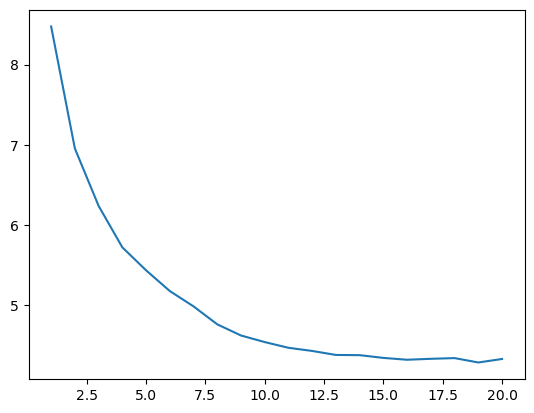

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(history_ppl) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl)
plt.show()

In [26]:
# Cargamos el mejor modelo guardado del entrenamiento para hacer inferencia
model = keras.models.load_model('my_model.keras')


### Predicción del próximo caracter

In [27]:
# Se puede usar gradio para probar el modelo
# Gradio es una herramienta muy útil para crear interfaces para ensayar modelos
# https://gradio.app/

!pip install -q gradio

python(59432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
import gradio as gr

def model_response(human_text):

    # Encodeamos
    encoded = [char2idx[ch] for ch in human_text.lower() ]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario el caracter
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    out_word = idx2char[y_hat]

    # Agrego la palabra a la frase predicha
    return human_text + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

python(59439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


### Generación de secuencias

In [ ]:
def generate_seq(model, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de caracteres a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = [char2idx[ch] for ch in output_text.lower() ]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		# Predicción softmax
        y_hat = np.argmax(model.predict(encoded,verbose=0)[0,-1,:])
		# Vamos concatenando las predicciones
        out_word = ''

        out_word = idx2char[y_hat]

		# Agrego las palabras a la frase predicha
        output_text += out_word
    return output_text

In [ ]:
input_text='habia una vez'

generate_seq(model, input_text, max_length=max_context_size, n_words=30)

###  Beam search y muestreo aleatorio

In [ ]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = [char2idx[ch] for ch in text]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return ''.join([idx2char[ch] for ch in seq])

In [ ]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens[:,-(len(input)+num_words):]

In [ ]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=20,input="habia una vez")

In [ ]:
salidas[0]

In [ ]:
# veamos las salidas
decode(salidas[0])

import matplotlib.pyplot as plt
import seaborn as sns

# Perplejidad
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, len(history_ppl)+1), y=history_ppl)
plt.title("Perplejidad por época")
plt.xlabel("Época")
plt.ylabel("Perplejidad")
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(8,4))
sns.lineplot(x=range(1, len(hist.history['accuracy'])+1), y=hist.history['accuracy'], label='Train accuracy')
plt.title("Precisión por época")
plt.xlabel("Época")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()